In [46]:
#Loading the necessary libraries

# Data
import fastf1 as ff1
from fastf1 import plotting
from fastf1 import utils

# Plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import seaborn as sns

# Data Manipulation
import numpy as np
import pandas as pd

In [47]:
#Enabling local cache speeds up loading of the data after the first initial load
ff1.Cache.enable_cache('/Users/bartosz/Data Projects/F1 Analysis/FastF1_Cache')

# Main variables used in every function

### Supporting Functions
Supporting functions used in the functions and throughout the notebook

In [48]:
#Supporting functions used in the functions and throughout the notebook

def convert_timedelta_from_lap(lap_information): #Choose lap from which to extract lap time and convert it to m:ss.mmm
    laptime = lap_information.LapTime
    
    return f"{laptime.seconds // 60}:{laptime.seconds % 60}.{laptime.microseconds//1000:3d}" #Returns lap time as str in format of m:ss.mmm


def drs_to_boolean(drs_value): #Convert DRS value to boolean
    if drs_value in [10, 12, 14]:
        return True  # DRS is enabled
    else:
        return False  # Every other value is treated as though the DRS is disabled

def nanoseconds_to_pandas_time(nanoseconds):
    # Convert nanoseconds to Timedelta
    delta = pd.to_timedelta(nanoseconds, unit='ns')
    
    # Extract total seconds
    total_seconds = delta.total_seconds()
    
    # Calculate minutes and seconds
    minutes = int(total_seconds // 60)
    seconds = total_seconds % 60
    
    # Format seconds to include milliseconds
    formatted_seconds = f"{seconds:.3f}".zfill(6)
    
    # Return formatted time as "m:ss.mmm"
    return f"{minutes}:{formatted_seconds}"

### Variables
The following variables, dictionaries and DataFrames are crucial for proper working of the plotting functions below. Please don't change them without prior knoweldge of how they work, to avoid issues.

In [ ]:
year_of_event = 2024 # Choose the year in which the event took place e.g. 2024 (int)
place_of_the_event = "Brazil" # Choose the place where the event took place e.g. "Singapore" (str)
session_of_the_event = "R" # Choose the session of the event e.g. "R" for race, "Q" for qualifying (str)

# Set driver_1 and driver_2 variables
driver_1, driver_2 = 'NOR', 'VER' # Choose two drivers to compare their laps (use official abbreviations) e.g. "NOR" for Norris, "VER" for Verstappen (str)

# Set the desired number of minisectors (default = 24) (int)
# Used for track dominance graphic
num_of_minisectors = 24 # Choose the number of sectors you want to use for visualisations



# Global Matplotlib settings
# They can be changed to make the plots look different
# Default makes the background dark
plt.style.use('dark_background')





# DON'T CHANGE THESE VARIABLES, UNLESS YOU HAVE THE KNOWLEDGE OF HOW THEY WORK
# CRUCIAL FOR PROPER WORKING OF LATER FUNCTIONS
# Main variables used for every other function that follows
# They are the backbone of the proper working of this notebook

# Loading the session information
schedule = ff1.get_event_schedule(year_of_event)
session = ff1.get_session(year_of_event, place_of_the_event, session_of_the_event)
session.load()





# Telemetry
# Get data for plotting laps and telemetry
laps_driver_1 = session.laps.pick_drivers(driver_1)
laps_driver_2 = session.laps.pick_drivers(driver_2)

team_driver_1 = ff1.plotting.get_team_name_by_driver(driver_1, session)
team_driver_2 = ff1.plotting.get_team_name_by_driver(driver_2, session)

full_telemetry_driver_1 = laps_driver_1.get_telemetry().add_distance()
full_telemetry_driver_2 = laps_driver_2.get_telemetry().add_distance()

full_telemetry_driver_1['Driver'] = driver_1 
full_telemetry_driver_2['Driver'] = driver_2

full_telemetry_driver_1['DRS_bool'] = full_telemetry_driver_1['DRS'].apply(drs_to_boolean)
full_telemetry_driver_2['DRS_bool'] = full_telemetry_driver_2['DRS'].apply(drs_to_boolean)

full_telemetry_merged = pd.concat([full_telemetry_driver_1, full_telemetry_driver_2], ignore_index=True)



fastest_lap_telemetry_driver_1 = laps_driver_1.pick_fastest().get_telemetry().add_distance()
fastest_lap_telemetry_driver_2 = laps_driver_2.pick_fastest().get_telemetry().add_distance()

fastest_lap_telemetry_driver_1['Driver'] = driver_1
fastest_lap_telemetry_driver_2['Driver'] = driver_2

fastest_lap_telemetry_driver_1['DRS_bool'] = fastest_lap_telemetry_driver_1['DRS'].apply(drs_to_boolean)
fastest_lap_telemetry_driver_2['DRS_bool'] = fastest_lap_telemetry_driver_2['DRS'].apply(drs_to_boolean)

fastest_lap_telemetry_merged = pd.concat([fastest_lap_telemetry_driver_1, fastest_lap_telemetry_driver_2], ignore_index=True)

quick_laps = session.laps.pick_quicklaps()

# Get team colors for coloring the plots later on
team_color_1 = ff1.plotting.get_team_color(team_driver_1, session)
team_color_2 = ff1.plotting.get_team_color(team_driver_2, session)





# Pace Comparison Variables
# Dictionaries with fastest and avg lap for each team
teams = list(session.laps['Team'].unique())

fastest_lap_times = {team: [] for team in session.laps['Team'].unique()}
avg_lap_times = {team: [] for team in session.laps['Team'].unique()}

for team in teams:
    fastest_lap_times[team] = session.laps.pick_teams(team)['LapTime'].min()
    avg_lap_times[team] = session.laps.pick_teams(team)['LapTime'].mean()

# Convert dictionaries to DataFrames for easier manipulation and calculation
df_fastest_lap_times = pd.DataFrame.from_dict(fastest_lap_times, orient='index', columns=['Fastest Lap']).reset_index()
df_avg_lap_times = pd.DataFrame.from_dict(avg_lap_times, orient='index', columns=['Avg Lap']).reset_index()
df_pace_comparison = pd.merge(df_fastest_lap_times, df_avg_lap_times, on="index")

df_pace_comparison.columns = ["Team", "Fastest Lap", "Avg Lap"]
df_pace_comparison["Percentage Diff Fast Lap"] = (((df_pace_comparison['Fastest Lap'] - df_pace_comparison['Fastest Lap'].min()) / df_pace_comparison['Fastest Lap'].min()) * 100).round(2)
df_pace_comparison["Percentage Diff Avg Lap"] = (((df_pace_comparison['Avg Lap'] - df_pace_comparison['Avg Lap'].min()) / df_pace_comparison['Avg Lap'].min()) * 100).round(2)
df_pace_comparison['Team Color'] = df_pace_comparison['Team'].apply(lambda team: ff1.plotting.get_team_color(team, session))





# Track Dominance
# Minisectors functions and data is used for plotting track dominance
minisector_length = max(fastest_lap_telemetry_merged['Distance'])/num_of_minisectors

# Add multiples of minisector_length to the minisectors variable
minisectors = [0]
for i in range(0, (num_of_minisectors - 1)):
    minisectors.append(minisector_length * (i + 1))

#Adding minisecotrs to both telemetry variables
fastest_lap_telemetry_merged['Minisector'] = fastest_lap_telemetry_merged['Distance'].apply(lambda dist: (min(int((dist // minisector_length) + 1), num_of_minisectors)))
full_telemetry_merged['Minisector'] = full_telemetry_merged['Distance'].apply(lambda dist: (min(int((dist // minisector_length) + 1), num_of_minisectors)))

#Extract faster driver in each minisector during their respective fastest lap
faster_driver_per_minisector_fastest_lap = (fastest_lap_telemetry_merged
    .groupby(['Minisector', 'Driver'])['Speed']
    .mean()
    .reset_index()
    .sort_values(['Minisector', 'Speed'], ascending=[True, False])
    .drop_duplicates('Minisector')
    [['Minisector', 'Driver']]
    .rename(columns={'Driver': 'Faster_driver'})
)

fastest_lap_telemetry_merged = fastest_lap_telemetry_merged.merge(faster_driver_per_minisector_fastest_lap, on=['Minisector']).sort_values(by=('Distance'))
fastest_lap_telemetry_merged.loc[fastest_lap_telemetry_merged['Faster_driver'] == driver_1, 'Faster_driver_int'] = 1
fastest_lap_telemetry_merged.loc[fastest_lap_telemetry_merged['Faster_driver'] == driver_2, 'Faster_driver_int'] = 2





# Lap Time Distribution
quick_laps['LapTimeTransformed'] = quick_laps.apply(lambda lap: convert_timedelta_from_lap(lap), axis=1)
quick_laps.loc[:, "LapTime (s)"] = quick_laps["LapTime"].dt.total_seconds()

team_order = (
    quick_laps[["LapTime", "Team"]]
    .groupby("Team")
    .median()["LapTime"]
    .sort_values()
    .index
)

team_palette = {team: ff1.plotting.get_team_color(team, session=session)
                for team in team_order}





# Lap Time Distribution of Point Scorers
point_finishers = session.drivers[:10]
print(point_finishers)
driver_laps = session.laps.pick_drivers(point_finishers).pick_quicklaps().reset_index()

finishing_order = session.results['Abbreviation'][:10]





# BACKUP OF OLDER VERSION OF FUNCTIONS


core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.4.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 23
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 23)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '31', '10', '63', '16'

['1', '31', '10', '63', '16', '4', '22', '81', '30', '44']


/var/folders/38/832j8mz95kqfxxr3cw5w_xgc0000gn/T/ipykernel_5372/1660667592.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quick_laps['LapTimeTransformed'] = quick_laps.apply(lambda lap: convert_timedelta_from_lap(lap), axis=1)
/var/folders/38/832j8mz95kqfxxr3cw5w_xgc0000gn/T/ipykernel_5372/1660667592.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quick_laps.loc[:, "LapTime (s)"] = quick_laps["LapTime"].dt.total_seconds()


In [59]:
team_palette[team_driver_1]

'#ff8000'

# Weather Data Visualisation

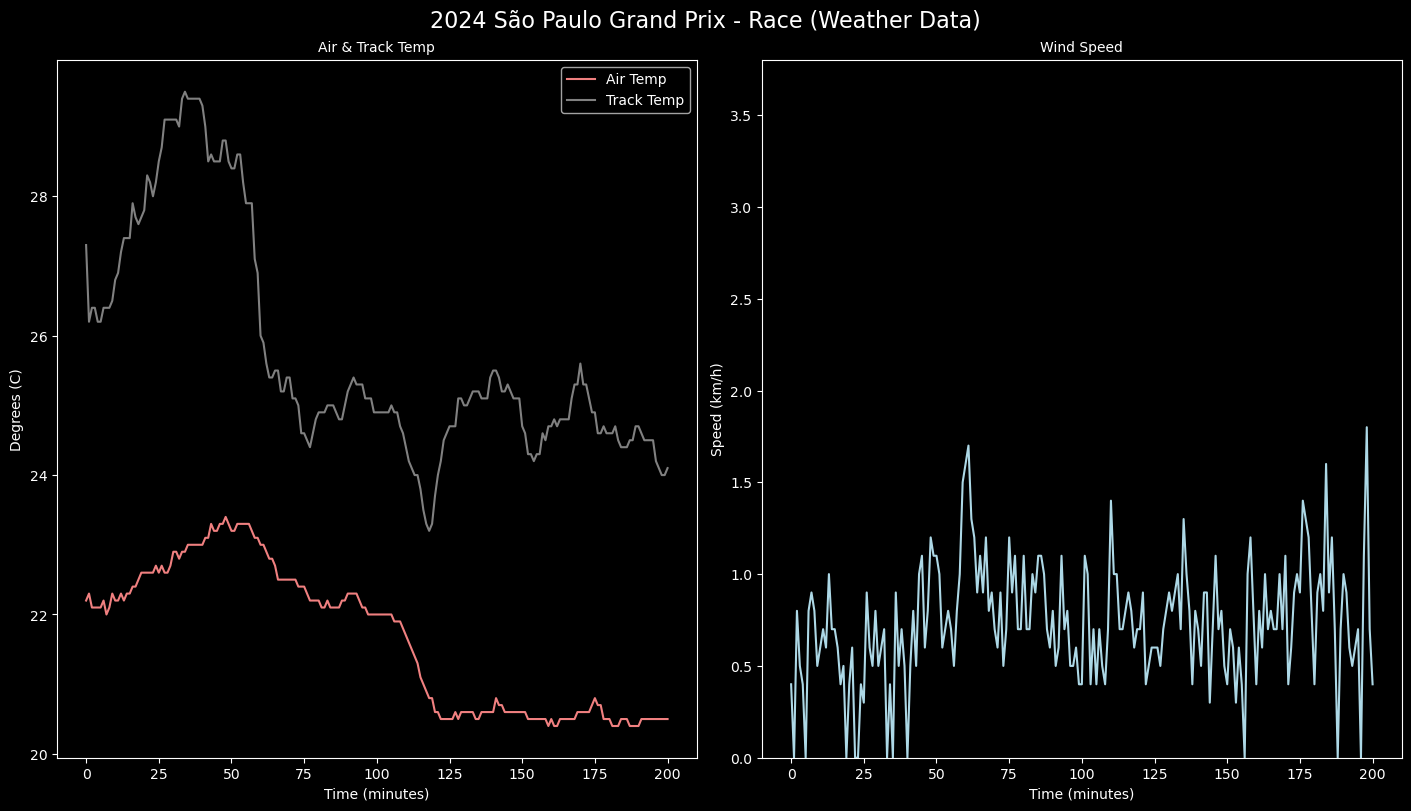

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 8), constrained_layout=True)

# Temperature Plot
ax[0].plot(session.weather_data.AirTemp, label='Air Temp', color='lightcoral')
ax[0].plot(session.weather_data.TrackTemp, label='Track Temp', color='grey')
ax[0].set_title('Air & Track Temp', fontsize=10)
ax[0].set_xlabel('Time (minutes)')
ax[0].set_ylabel('Degrees (C)')
ax[0].legend()

# Wind Speed
ax[1].plot(session.weather_data.WindSpeed, label='Wind Speed', color='lightblue')
ax[1].set_title('Wind Speed', fontsize=10)
ax[1].set_xlabel('Time (minutes)')
ax[1].set_ylabel('Speed (km/h)')
ax[1].set_ylim(max(0, session.weather_data.WindSpeed.min() - 2), session.weather_data.WindSpeed.max() + 2)

plt.suptitle(f"{session.event.year} {session.event.EventName} - {session.name} (Weather Data)", fontsize=16)

plt.show()

# Track Dominance

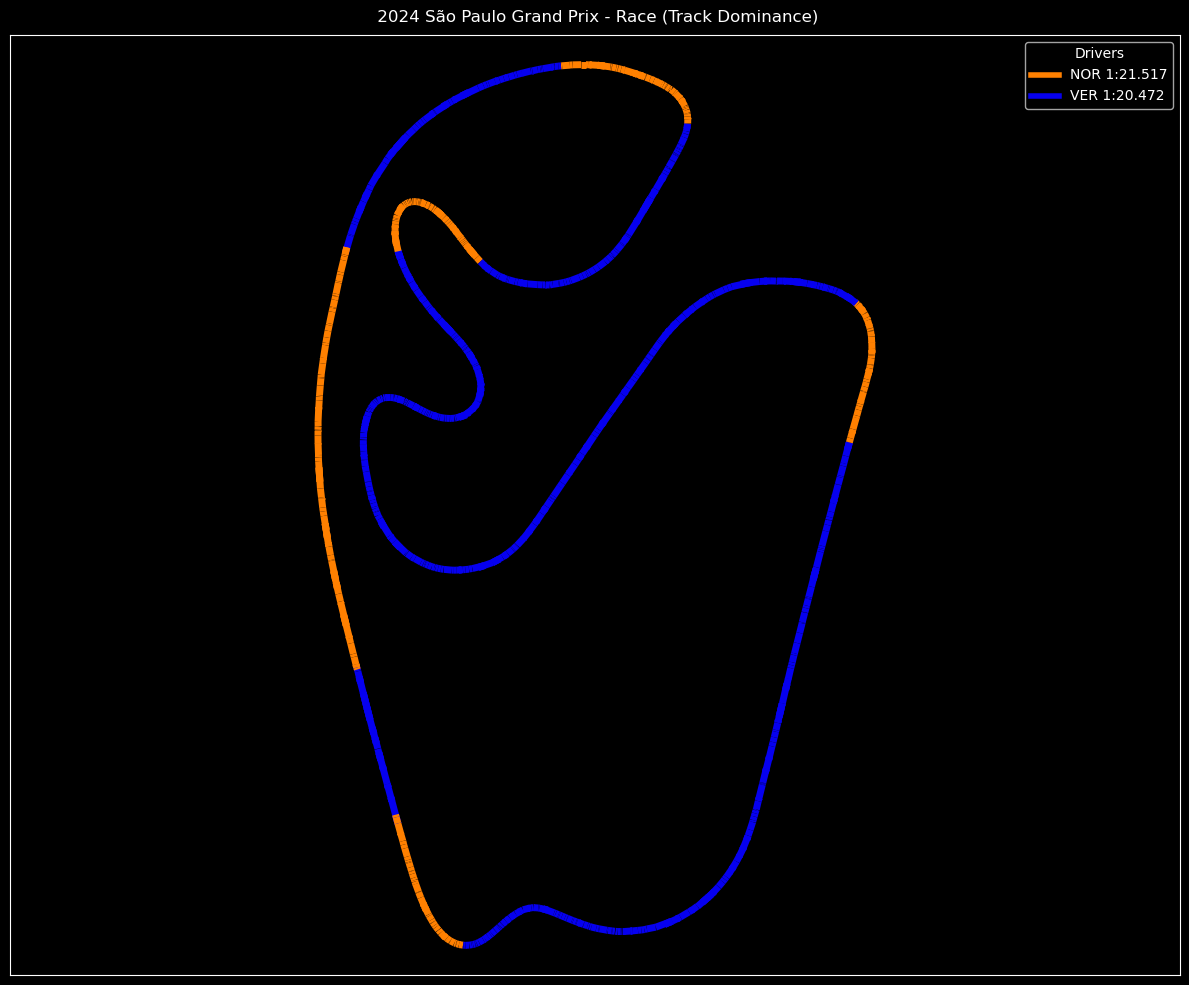

In [51]:
# Convert hex colors to RGBA format
cmap = cm.colors.ListedColormap([team_color_1, team_color_2])

x = np.array(fastest_lap_telemetry_merged['X'].values)
y = np.array(fastest_lap_telemetry_merged['Y'].values)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fastest_driver_array = fastest_lap_telemetry_merged['Faster_driver_int'].to_numpy().astype(float)

lc_comp = LineCollection(segments, norm=plt.Normalize(1, 2), cmap=cmap)
lc_comp.set_array(fastest_driver_array)
lc_comp.set_linewidth(5)

plt.rcParams['figure.figsize'] = [12, 10]

plt.gca().add_collection(lc_comp)
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
plt.suptitle(f" {session.event.year} {session.event.EventName} - {session.name} (Track Dominance)")

legend_lines = [
    Line2D([0], [0], color=team_color_1, lw=4, label=f"{driver_1} {convert_timedelta_from_lap(laps_driver_1.pick_fastest())}"),
    Line2D([0], [0], color=team_color_2, lw=4, label=f"{driver_2} {convert_timedelta_from_lap(laps_driver_2.pick_fastest())}")
]

plt.tight_layout()
plt.legend(handles=legend_lines, loc="upper right", title="Drivers")
plt.show()

# Telemetry

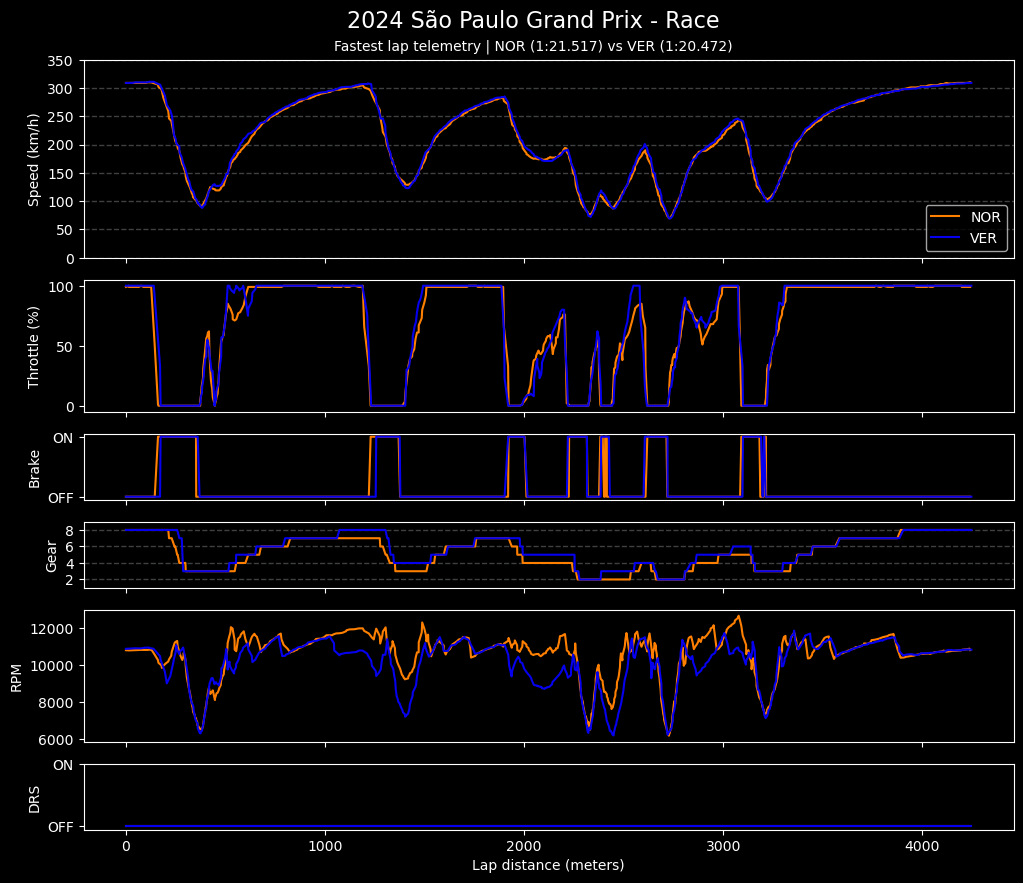

In [52]:
fig, ax = plt.subplots(6, gridspec_kw={'height_ratios': [3, 2, 1, 1, 2, 1]}, constrained_layout=False)


# Speed trace
ax[0].plot(fastest_lap_telemetry_driver_1['Distance'], fastest_lap_telemetry_driver_1['Speed'], label=driver_1, color=team_color_1)
ax[0].plot(fastest_lap_telemetry_driver_2['Distance'], fastest_lap_telemetry_driver_2['Speed'], label=driver_2, color=team_color_2)
ax[0].set_ylabel('Speed (km/h)', color='white')
ax[0].legend(loc="lower right")
ax[0].set_yticks([350, 300, 250, 200, 150, 100, 50, 0])
ax[0].yaxis.grid(color='#3E4041', linestyle='--', linewidth=1)

# Throttle trace
ax[1].plot(fastest_lap_telemetry_driver_1['Distance'], fastest_lap_telemetry_driver_1['Throttle'], label=driver_1, color=team_color_1)
ax[1].plot(fastest_lap_telemetry_driver_2['Distance'], fastest_lap_telemetry_driver_2['Throttle'], label=driver_2, color=team_color_2)
ax[1].set_ylabel('Throttle (%)', color='white')

# Brake trace
ax[2].plot(fastest_lap_telemetry_driver_1['Distance'], fastest_lap_telemetry_driver_1['Brake'], label=driver_1, color=team_color_1)
ax[2].plot(fastest_lap_telemetry_driver_2['Distance'], fastest_lap_telemetry_driver_2['Brake'], label=driver_2, color=team_color_2)
ax[2].set_ylabel('Brake', color='white')
ax[2].set_yticks([0, 1])
ax[2].set_yticklabels(['OFF', 'ON'])

# Gear trace
ax[3].plot(fastest_lap_telemetry_driver_1['Distance'], fastest_lap_telemetry_driver_1['nGear'], label=driver_1, color=team_color_1)
ax[3].plot(fastest_lap_telemetry_driver_2['Distance'], fastest_lap_telemetry_driver_2['nGear'], label=driver_2, color=team_color_2)
ax[3].set_ylabel('Gear', color='white')
ax[3].set_yticks([2, 4, 6, 8])
ax[3].set_ylim([1, 9])
ax[3].yaxis.grid(color='#3E4041', linestyle='--', linewidth=1)

# RPM trace
ax[4].plot(fastest_lap_telemetry_driver_1['Distance'], fastest_lap_telemetry_driver_1['RPM'], label=driver_1, color=team_color_1)
ax[4].plot(fastest_lap_telemetry_driver_2['Distance'], fastest_lap_telemetry_driver_2['RPM'], label=driver_2, color=team_color_2)
ax[4].set_ylabel('RPM', color='white')

# DRS trace
ax[5].plot(fastest_lap_telemetry_driver_1['Distance'], fastest_lap_telemetry_driver_1['DRS_bool'], label=driver_1, color=team_color_1)
ax[5].plot(fastest_lap_telemetry_driver_2['Distance'], fastest_lap_telemetry_driver_2['DRS_bool'], label=driver_2, color=team_color_2)
ax[5].set_ylabel('DRS', color='white')
ax[5].set_xlabel('Lap distance (meters)', color='white')
ax[5].set_yticks([False, True])
ax[5].set_yticklabels(['OFF', 'ON'])

# Ensure only the bottom has distance lables
for a in ax:
    a.label_outer()
    a.spines['top'].set_color('white')
    a.spines['right'].set_color('white')

# Set the main plot title using fig.suptitle
fig.suptitle(f"{session.event.year} {session.event.EventName} - {session.name}", fontsize=16, color='white', y=0.93)
fig.text(0.5, 0.89, f"Fastest lap telemetry | {driver_1} ({convert_timedelta_from_lap(laps_driver_1.pick_fastest())}) vs {driver_2} ({convert_timedelta_from_lap(laps_driver_2.pick_fastest())})", ha='center', fontsize=10)

plt.show()

# Lap Time Distributions

## General Lap Time Distribution

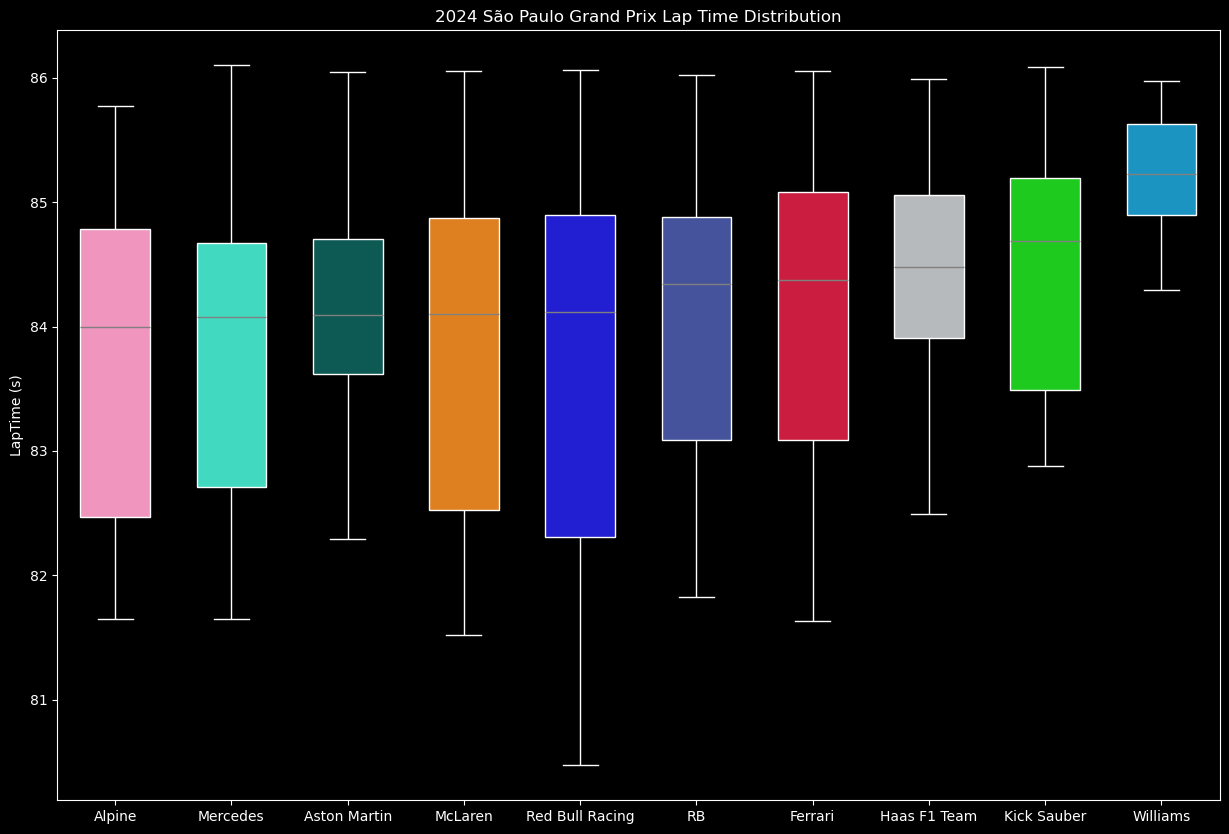

In [53]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.boxplot(
    data=quick_laps,
    x="Team",
    y="LapTime (s)",
    hue="Team",
    order=team_order,
    palette=team_palette,
    whiskerprops=dict(color="white"),
    boxprops=dict(edgecolor="white"),
    medianprops=dict(color="grey"),
    capprops=dict(color="white"),
    flierprops=dict(marker='o', markerfacecolor='lightgrey', markersize=5, linestyle='none'),
    width=0.6,
    dodge=False
)

plt.title(f"{session.event.year} {session.event.EventName} Lap Time Distribution")
plt.grid(visible=False)

# x-label is redundant
ax.set(xlabel=None)
plt.show()

## Lap Time Distribution of Point Scorers

/var/folders/38/832j8mz95kqfxxr3cw5w_xgc0000gn/T/ipykernel_5372/3325371448.py:5: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=driver_laps,


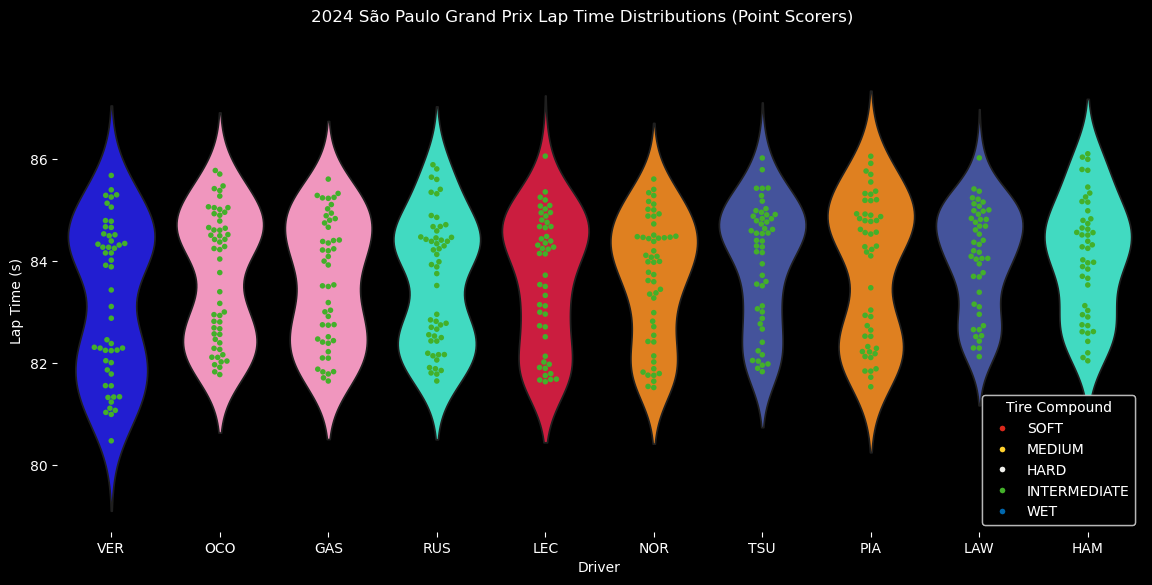

In [60]:
fig, ax = plt.subplots(figsize=(14, 6))

driver_laps["LapTime(s)"] = driver_laps["LapTime"].dt.total_seconds()

sns.violinplot(data=driver_laps,
                x="Driver",
                y="LapTime(s)",
                hue="Driver",
                inner=None,
                scale="width",
                density_norm="area",
                order=finishing_order,
                dodge=False,
                palette=ff1.plotting.get_driver_color_mapping(session=session),
                ax=ax
                )

sns.swarmplot(data=driver_laps,
               x="Driver",
               y="LapTime(s)",
               order=finishing_order,
               hue="Compound",
               palette=ff1.plotting.get_compound_mapping(session=session),
               hue_order=["SOFT", "MEDIUM", "HARD", "INTERMEDIATE", "WET"],
               dodge=False,
               linewidth=0,
               size=4,
               ax=ax
               )

ax.set_xlabel("Driver")
ax.set_ylabel("Lap Time (s)")
plt.suptitle(f"{session.event.year} {session.event.EventName} Lap Time Distributions (Point Scorers)")
sns.despine(left=True, bottom=True)

handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))

compound_handles = [handles[i] for i, label in enumerate(labels) if label in ["SOFT", "MEDIUM", "HARD", "INTERMEDIATE", "WET"]]
legend2 = ax.legend(compound_handles, ["SOFT", "MEDIUM", "HARD", "INTERMEDIATE", "WET"], title='Tire Compound', loc='lower right', bbox_to_anchor=(1, 0))
ax.add_artist(legend2)

plt.show()

# Pace Comparisons

## Fastest Lap Team Pace Comparison

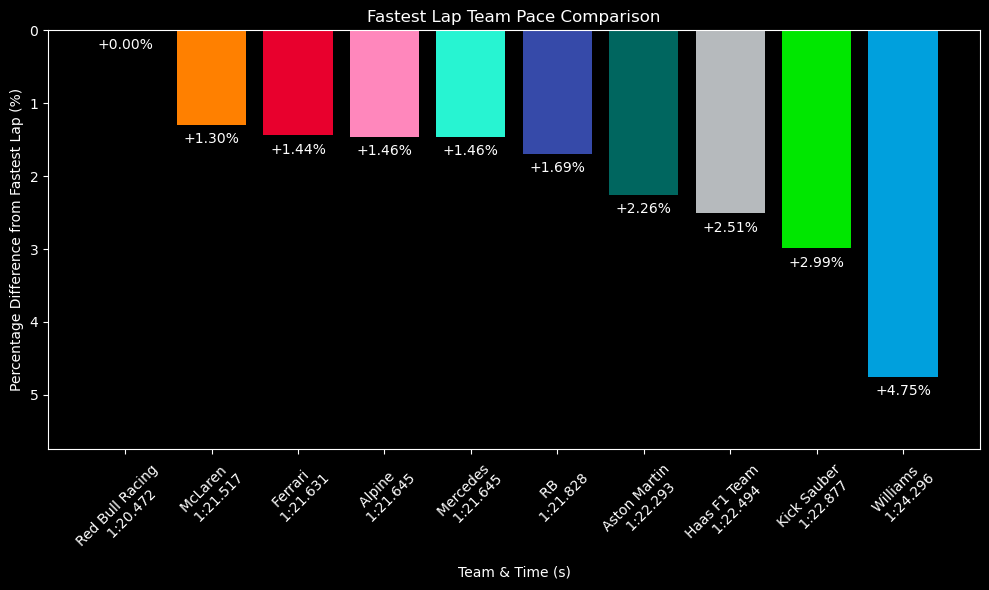

In [55]:
df_pace_comparison.sort_values("Percentage Diff Fast Lap", inplace=True)

plt.figure(figsize=(10, 6))

plt.bar(df_pace_comparison['Team'], df_pace_comparison['Percentage Diff Fast Lap'], color=df_pace_comparison['Team Color'])

plt.ylabel('Percentage Difference from Fastest Lap (%)')
plt.xlabel('Team & Time (s)')
plt.title('Fastest Lap Team Pace Comparison')

# Rotate team names for better readability
plt.xticks(ticks=np.arange(10), rotation=45, labels=[f"{team} \n {nanoseconds_to_pandas_time(avg_team_lap)}" for team, avg_team_lap in zip(df_pace_comparison['Team'], df_pace_comparison['Fastest Lap'])])

plt.ylim(df_pace_comparison['Percentage Diff Fast Lap'].max()+1, 0)

for index, value in enumerate(df_pace_comparison['Percentage Diff Fast Lap']):
    plt.text(index, value + 0.1, f"+{value:.2f}%", ha='center', va='top')

plt.tight_layout()
plt.show()

## Avg Lap Team Pace Comparison

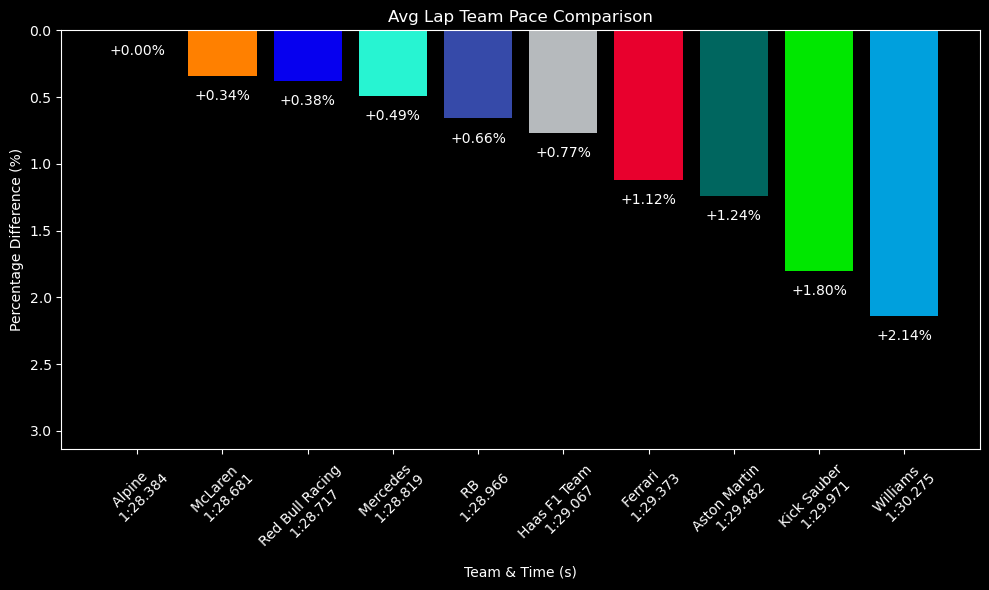

In [56]:
df_pace_comparison.sort_values('Percentage Diff Avg Lap', inplace = True)

plt.figure(figsize=(10, 6))

plt.bar(df_pace_comparison['Team'], df_pace_comparison['Percentage Diff Avg Lap'], color=df_pace_comparison['Team Color'])

plt.ylabel('Percentage Difference (%)')
plt.xlabel('Team & Time (s)')
plt.title('Avg Lap Team Pace Comparison')

plt.xticks(ticks=np.arange(10), rotation=45, labels=[f"{team} \n {nanoseconds_to_pandas_time(avg_team_lap)}" for team, avg_team_lap in zip(df_pace_comparison['Team'], df_pace_comparison['Avg Lap'])])

plt.ylim(df_pace_comparison['Percentage Diff Avg Lap'].max()+1, 0)

for index, value in enumerate(df_pace_comparison['Percentage Diff Avg Lap']):
    plt.text(index, value + 0.1, f"+{value:.2f}%", ha='center', va='top')

plt.tight_layout()

plt.show()

## Fastest & Avg Lap Team Pace Comparison

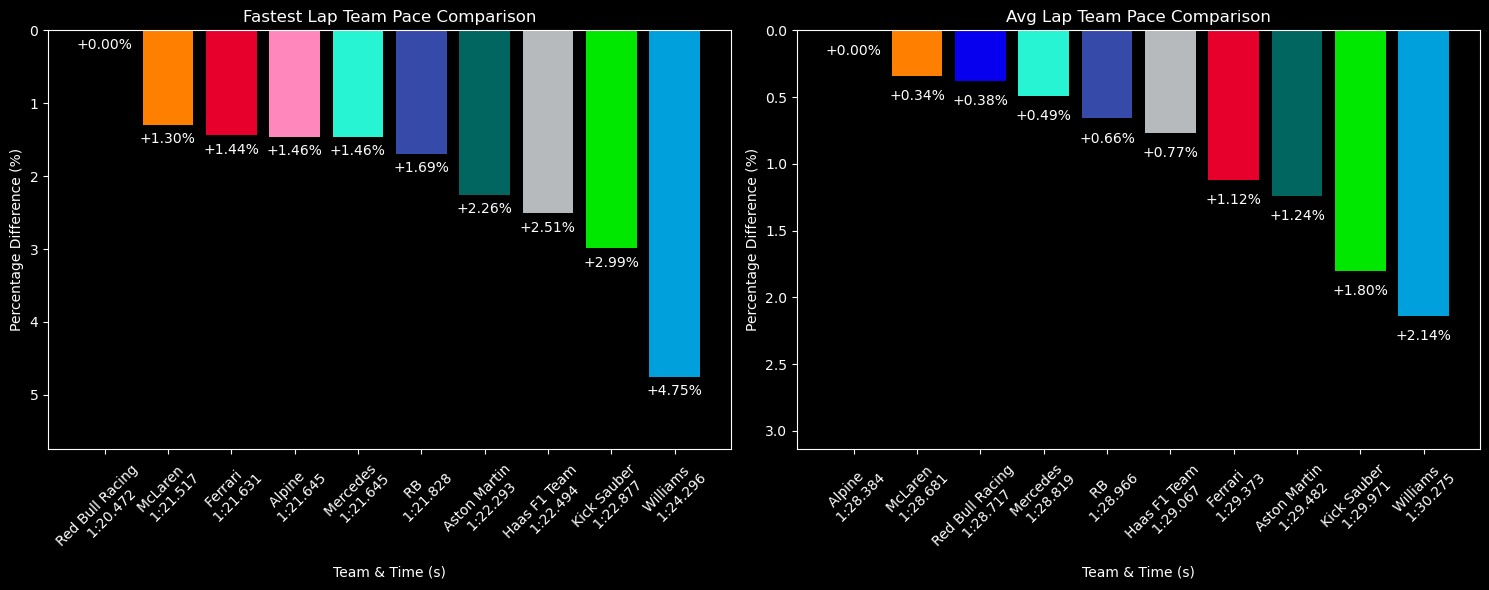

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

df_pace_comparison.sort_values("Percentage Diff Fast Lap", inplace=True)

axes[0].bar(df_pace_comparison['Team'], df_pace_comparison['Percentage Diff Fast Lap'], color=df_pace_comparison['Team Color'])
axes[0].set_ylabel('Percentage Difference (%)')
axes[0].set_xlabel('Team & Time (s)')
axes[0].set_title('Fastest Lap Team Pace Comparison')
axes[0].set_xticks(np.arange(10))
axes[0].set_xticklabels([f"{team} \n {nanoseconds_to_pandas_time(avg_team_lap)}" for team, avg_team_lap in zip(df_pace_comparison['Team'], df_pace_comparison['Fastest Lap'])], rotation=45)
axes[0].set_ylim(df_pace_comparison['Percentage Diff Fast Lap'].max() + 1, 0)

for index, value in enumerate(df_pace_comparison['Percentage Diff Fast Lap']):
    axes[0].text(index, value + 0.1, f"+{value:.2f}%", ha='center', va='top')



df_pace_comparison.sort_values("Percentage Diff Avg Lap", inplace=True)

axes[1].bar(df_pace_comparison['Team'], df_pace_comparison["Percentage Diff Avg Lap"], color=df_pace_comparison['Team Color'])
axes[1].set_ylabel('Percentage Difference (%)')
axes[1].set_xlabel('Team & Time (s)')
axes[1].set_title('Avg Lap Team Pace Comparison')
axes[1].set_xticks(np.arange(10))
axes[1].set_xticklabels([f"{team} \n {nanoseconds_to_pandas_time(avg_team_lap)}" for team, avg_team_lap in zip(df_pace_comparison['Team'], df_pace_comparison['Avg Lap'])], rotation=45)
axes[1].set_ylim(df_pace_comparison["Percentage Diff Avg Lap"].max() + 1, 0)

for index, value in enumerate(df_pace_comparison["Percentage Diff Avg Lap"]):
    axes[1].text(index, value + 0.1, f"+{value:.2f}%", ha='center', va='top')

plt.tight_layout()
plt.show()
